In [192]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [193]:
%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [194]:
s=os.getcwd()
print(s)
pd.set_option('display.max_columns', 10)

/Users/harshitjain/PycharmProjects/kaggle


In [195]:
items = pd.read_csv(s+'/all/items.csv')
shops = pd.read_csv(s+'/all/shops.csv')
cats = pd.read_csv(s+'/all/item_categories.csv')
sales = pd.read_csv(s+'/all/sales_train.csv')
test = pd.read_csv(s+'/all/test.csv')

In [196]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [197]:
train.shape

(2935849, 10)

In [198]:
print(train.describe(include="all"))

              date  date_block_num    shop_id    item_id  item_price  \
count      2935849      2935849.00 2935849.00 2935849.00  2935849.00   
unique        1034             nan        nan        nan         nan   
top     28.12.2013             nan        nan        nan         nan   
freq          9434             nan        nan        nan         nan   
mean           NaN           14.57      33.00   10197.23      890.85   
std            NaN            9.42      16.23    6324.30     1729.80   
min            NaN            0.00       0.00       0.00       -1.00   
25%            NaN            7.00      22.00    4476.00      249.00   
50%            NaN           14.00      31.00    9343.00      399.00   
75%            NaN           23.00      47.00   15684.00      999.00   
max            NaN           33.00      59.00   22169.00   307980.00   

        item_cnt_day                                          item_name  \
count     2935849.00                                        

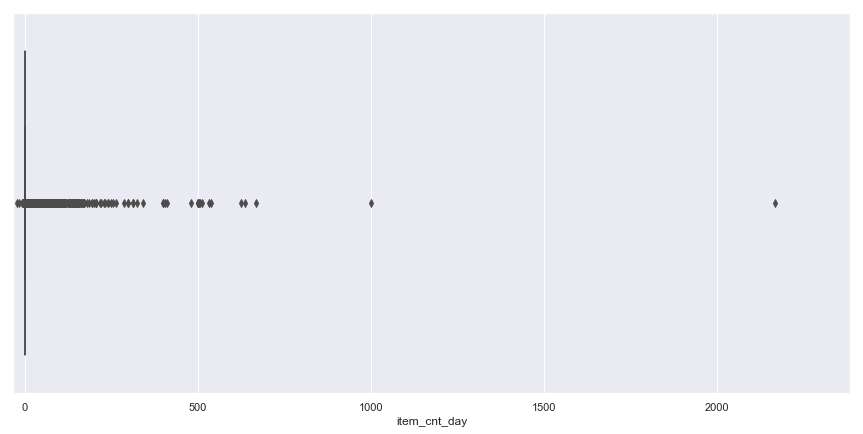

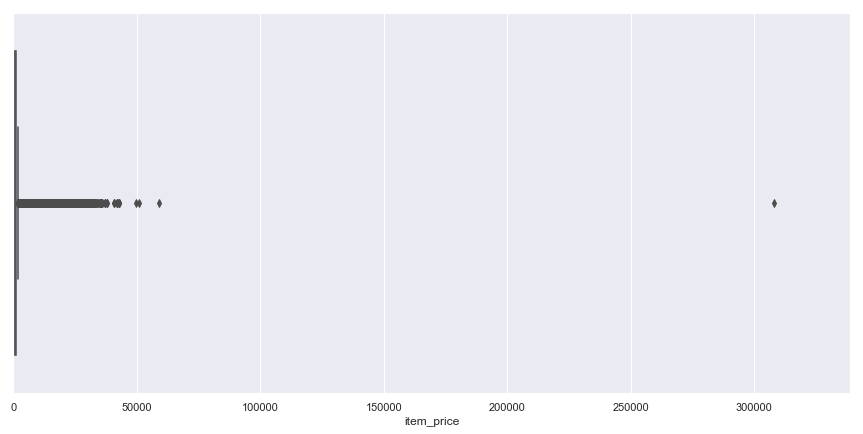

In [199]:
plt.figure(figsize=(15,7))
plt.xlim(train.item_cnt_day.min()*1.5, train.item_cnt_day.max()*1.1)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(15,7))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [200]:
median = train.item_price.median()
train.loc[train.item_price<0, 'item_price'] = median
train = train[train.item_price<100000]

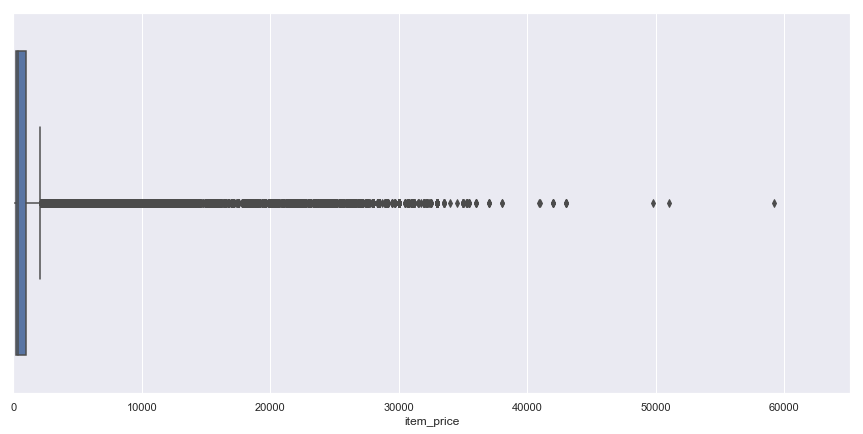

In [201]:
plt.figure(figsize=(15,7))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [202]:
train = train[train.item_cnt_day<1500 and train.item_cnt_day>0]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
print(test_item_ids.shape)
lk_train = train[train['shop_id'].isin(test_shop_ids)]
print(train.shape)
print(lk_train.shape)
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]
print(lk_train.shape)

In [ ]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [ ]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)

In [ ]:
print(train_monthly.head())

In [ ]:
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [ ]:
print(train_monthly.head())

In [ ]:
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [ ]:
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [ ]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [ ]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [ ]:
monthly_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
monthly_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

In [ ]:
plt.figure(figsize=(22, 8))
sns.boxplot(x=train_monthly.item_cnt)
plt.show()

In [ ]:
train_monthly.dtypes

In [ ]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [ ]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [ ]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [ ]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [ ]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [ ]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)


In [ ]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [ ]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

In [ ]:
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [ ]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [ ]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [ ]:
sets = [X_train, X_validation, X_test]
           
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
X_test.fillna(X_test.mean(), inplace=True)

In [ ]:
print(X_test.head().T)

In [ ]:
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

In [ ]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [ ]:
from sklearn.metrics import mean_squared_error

In [204]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 1.9239633447826523
Validation rmse: 1.5043044575066464


In [203]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = rf_test_pred
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)


,ID,item_cnt_month
0,0,0.93
1,1,0.16
2,2,1.42
3,3,0.16
4,4,0.16
5,5,0.93
6,6,2.06
7,7,0.16
8,8,2.06
9,9,0.16
